## 1.  Import libraries

In [1]:
# import libraries
import numpy as np
import pandas as pd 
import scipy 
import math 
from datetime import datetime 
import datetime as dt 
import matplotlib.pyplot as plt 

from statsmodels.tsa.stattools import pacf
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## 2. Import data

In [2]:
sp_data = pd.read_csv('SP500_FRED _11_21.csv')

## 3. Initial data inspection

In [3]:
sp_data.head()

,date,value
0,10/07/2011,1155.5
1,10/10/2011,1194.9
2,10/11/2011,1195.5
3,10/12/2011,1207.3
4,10/13/2011,1203.7


In [4]:
sp_data.shape

(2609, 2)

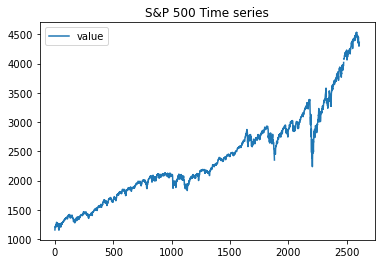

In [5]:
# plotting the value with the raw data
sp_data.plot()
plt.title('S&P 500 Time series')
plt.show()

In [3]:
#copying the data
sp500 = sp_data.copy()

In [4]:
# changing values to numeric
sp500['price'] = pd.to_numeric(sp500.value, errors='coerce')

# remove null values from the df
sp500.dropna(inplace = True)

In [5]:
sp500.shape

(2516, 3)

In [6]:
sp500.head()

,date,value,price
0,10/07/2011,1155.5,1155.5
1,10/10/2011,1194.9,1194.9
2,10/11/2011,1195.5,1195.5
3,10/12/2011,1207.3,1207.3
4,10/13/2011,1203.7,1203.7


In [7]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2516 entries, 0 to 2608
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    2516 non-null   object 
 1   value   2516 non-null   float64
 2   price   2516 non-null   float64
dtypes: float64(2), object(1)
memory usage: 78.6+ KB


## 4. Plotting the timeseries data

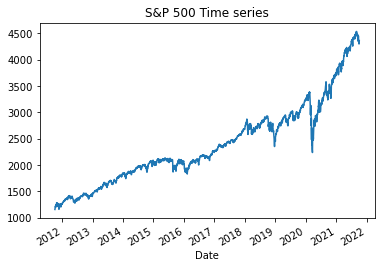

In [9]:
# creating date based index
sp500.index = pd.to_datetime(sp500.date)
sp500.price.plot()
plt.title('S&P 500 Time series')
plt.xlabel('Date')
plt.show()

The data is clearly trending. So, to make it stationary let's plot the differences.

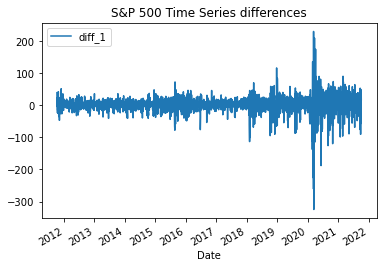

In [10]:
sp500['diff_1'] = sp500.price - sp500.price.shift(1)
sp500.plot(y='diff_1')
plt.title('S&P 500 Time Series differences')
plt.xlabel('Date')
plt.show()

In [11]:
sp500.head()

,date,value,price,diff_1
date,,,,
2011-10-07,10/07/2011,1155.5,1155.5,NaN
2011-10-10,10/10/2011,1194.9,1194.9,39.4
2011-10-11,10/11/2011,1195.5,1195.5,0.6
2011-10-12,10/12/2011,1207.3,1207.3,11.8
2011-10-13,10/13/2011,1203.7,1203.7,-3.6


Text(0.5, 1.0, 'S&P 500 PACF')

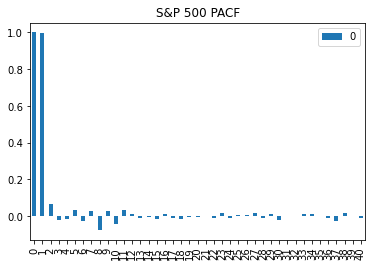

In [12]:
# Plotting PACF
x_acf = pd.DataFrame(pacf(sp500.price))
x_acf.plot(kind='bar')
plt.title("S&P 500 PACF")

There seems to have one strong autocorrelation (the first two bars)

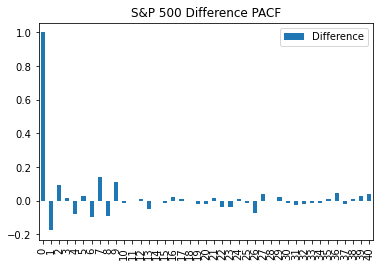

In [13]:
# pacf with the differences with prices
x_acf = pd.DataFrame(pacf(sp500.diff_1[1:]))
x_acf.plot(kind='bar')
plt.title("S&P 500 Difference PACF")
plt.legend(['Difference'])

Differences in the time series showed no autocorrelation.

## 5. Building models (ARIMA)

AR = Past value<br>
I = Level of differencing<br>
MA = Adjusting to past errors

### 5.1 Grid search hyperparameters of ARIMA

In [27]:
def tune_ARIMA(X, arima_order):
    # prepare training data
    train_data_size = int(len(X)*0.80)
    train, test = X[0:train_data_size], X[train_data_size:]
    history = [x for x in train]
    # making prediction
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order = arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0] 
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse
# evaluating combinations of p, d and q
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None 
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = tune_ARIMA(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE= %.3f' %(order, rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE = %.3f' %(best_cfg, best_score))
#load dataset
series = sp500.price
p_values = [0,1,2,4]
d_values = range(0,2) 
q_values = range(0,2) 
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE= 1420.202
ARIMA(0, 0, 1) RMSE= 725.641
ARIMA(0, 1, 0) RMSE= 48.121
ARIMA(0, 1, 1) RMSE= 47.434
ARIMA(1, 0, 0) RMSE= 48.154
ARIMA(1, 0, 1) RMSE= 47.480
ARIMA(1, 1, 0) RMSE= 47.302
ARIMA(1, 1, 1) RMSE= 47.338
ARIMA(2, 0, 0) RMSE= 47.331
ARIMA(2, 0, 1) RMSE= 47.415
ARIMA(2, 1, 0) RMSE= 47.325
ARIMA(2, 1, 1) RMSE= 47.560
ARIMA(4, 0, 0) RMSE= 81841081.553
ARIMA(4, 0, 1) RMSE= 46.883
ARIMA(4, 1, 0) RMSE= 47.622
ARIMA(4, 1, 1) RMSE= 234.222
Best ARIMA(4, 0, 1) RMSE = 46.883


ARIMA(0, 0, 0) RMSE= 1420.202<br>
ARIMA(0, 0, 1) RMSE= 725.641<br>
ARIMA(0, 1, 0) RMSE= 48.121<br>
ARIMA(0, 1, 1) RMSE= 47.434<br>
ARIMA(1, 0, 0) RMSE= 48.154<br>
ARIMA(1, 0, 1) RMSE= 47.480<br>
ARIMA(1, 1, 0) RMSE= 47.302<br>
ARIMA(1, 1, 1) RMSE= 47.338<br>
ARIMA(2, 0, 0) RMSE= 47.331<br>
ARIMA(2, 0, 1) RMSE= 47.415<br>
ARIMA(2, 1, 0) RMSE= 47.325<br>
ARIMA(2, 1, 1) RMSE= 47.560<br>
ARIMA(4, 0, 0) RMSE= 81841081.553<br>
ARIMA(4, 0, 1) RMSE= 46.883<br>
ARIMA(4, 1, 0) RMSE= 47.622<br>
ARIMA(4, 1, 1) RMSE= 234.222<br>
Best ARIMA(4, 0, 1) RMSE = 46.883<br>

### 5.2 ARIMA Model comparision

In [35]:

model = ARIMA(sp500.price, order =(0,0,1))
model_fit = model.fit() 
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                              ARMA Model Results                              
Dep. Variable:                  price   No. Observations:                 2516
Model:                     ARMA(0, 1)   Log Likelihood              -18612.386
Method:                       css-mle   S.D. of innovations            394.638
Date:                Fri, 08 Oct 2021   AIC                          37230.771
Time:                        21:27:08   BIC                          37248.263
Sample:                             0   HQIC                         37237.119
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2391.7907     15.616    153.160      0.000    2361.183    2422.398
ma.L1.price     0.9853      0.002    402.159      0.000       0.980       0.990
                                    Roots       

In [28]:
model_101 = ARIMA(sp500.price, order =(1,0,1))
model_101_fit = model_101.fit() 
print(model_101_fit.summary())
print('Residuals Description')
print(model_101_fit.resid.describe())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 2516
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -11822.182
Date:                Tue, 12 Oct 2021   AIC                          23652.365
Time:                        02:10:51   BIC                          23675.686
Sample:                             0   HQIC                         23660.829
                               - 2516                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2391.8086   2373.259      1.008      0.314   -2259.694    7043.311
ar.L1          0.9999      0.001   1513.546      0.000       0.999       1.001
ma.L1         -0.1438      0.007    -21.052      0.0

In [27]:
model_110 = ARIMA(sp500.price, order =(1,1,0))
model_110_fit = model_110.fit() 
print(model_110_fit.summary())
print('Residuals Description')
print(model_110_fit.resid.describe())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 2516
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -11806.776
Date:                Tue, 12 Oct 2021   AIC                          23617.552
Time:                        02:06:39   BIC                          23629.213
Sample:                             0   HQIC                         23621.784
                               - 2516                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1733      0.006    -27.483      0.000      -0.186      -0.161
sigma2       699.7582      6.106    114.594      0.000     687.790     711.727
Ljung-Box (L1) (Q):                   0.43   Jarque-

Text(0.5, 1.0, 'Histogram of Residuals')

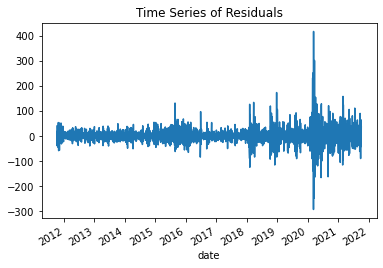

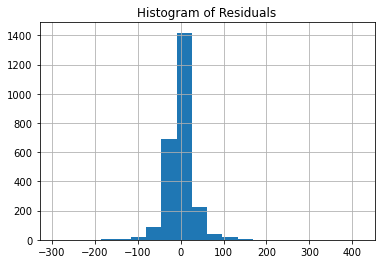

In [16]:
# plotting residuals
residuals = pd.DataFrame(model_110_fit.resid)

residuals.plot(legend=False)
plt.title('Time Series of Residuals')

residuals.hist(bins=20)
plt.title('Histogram of Residuals')

In [26]:
model_111 = ARIMA(sp500.price, order =(1,1,1))
model_111_fit = model_111.fit() 
print(model_111_fit.summary())
print('Residuals Description')
print(model_111_fit.resid.describe())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 2516
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -11800.111
Date:                Tue, 12 Oct 2021   AIC                          23606.221
Time:                        02:06:05   BIC                          23623.711
Sample:                             0   HQIC                         23612.569
                               - 2516                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4473      0.028    -15.695      0.000      -0.503      -0.391
ma.L1          0.2766      0.031      8.877      0.000       0.216       0.338
sigma2       696.3640      6.180    112.673      0.0

Text(0.5, 1.0, 'Histogram of Residuals')

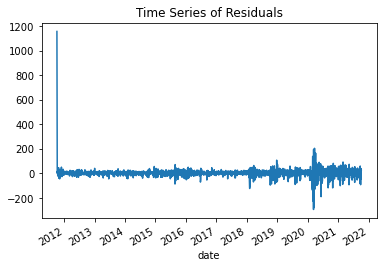

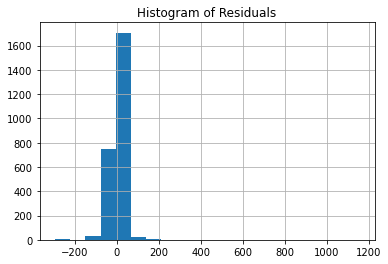

In [21]:
# plotting residuals 111
residuals = pd.DataFrame(model_111_fit.resid)

residuals.plot(legend=False)
plt.title('Time Series of Residuals')

residuals.hist(bins=20)
plt.title('Histogram of Residuals')

There is no clear trend in residuals. <br>
Residuals are approximate a normal distribution. <br>


In [25]:
model = ARIMA(sp500.price, order =(1,1,4))
model_fit = model.fit() 
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 2516
Model:                 ARIMA(1, 1, 4)   Log Likelihood              -11766.042
Date:                Tue, 12 Oct 2021   AIC                          23544.084
Time:                        02:04:15   BIC                          23579.065
Sample:                             0   HQIC                         23556.780
                               - 2516                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8096      0.022    -36.085      0.000      -0.854      -0.766
ma.L1          0.6741      0.023     28.862      0.000       0.628       0.720
ma.L2         -0.0186      0.010     -1.818      0.0

In [24]:
model = ARIMA(sp500.price, order =(4,1,4))
model_fit = model.fit() 
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 2516
Model:                 ARIMA(4, 1, 4)   Log Likelihood              -11786.052
Date:                Tue, 12 Oct 2021   AIC                          23590.104
Time:                        02:03:47   BIC                          23642.574
Sample:                             0   HQIC                         23609.147
                               - 2516                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1504      0.043     -3.535      0.000      -0.234      -0.067
ar.L2          0.5077      0.066      7.661      0.000       0.378       0.638
ar.L3         -0.5980      0.064     -9.307      0.0

(4,1,4)= Residuals are not independent L-Box is < 0.05

In [22]:
model_401 = ARIMA(sp500.price, order =(4,0,1))
model_401_fit = model.fit() 
print(model_401_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 2516
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -11853.831
Date:                Tue, 12 Oct 2021   AIC                          23713.662
Time:                        02:01:26   BIC                          23731.153
Sample:                             0   HQIC                         23720.010
                               - 2516                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2391.9224    905.326      2.642      0.008     617.516    4166.329
ar.L1          0.9997      0.001   1491.657      0.000       0.998       1.001
sigma2       721.8406      6.001    120.291      0.0

Text(0.5, 1.0, 'Histogram of Residuals')

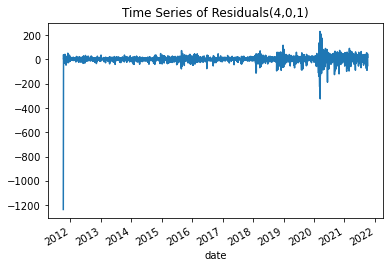

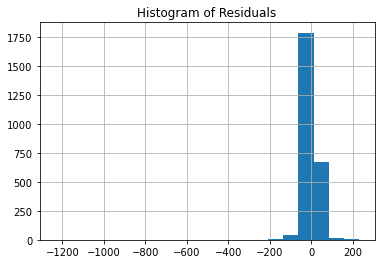

In [23]:
# plotting residuals
residuals = pd.DataFrame(model_401_fit.resid)

residuals.plot(legend=False)
plt.title('Time Series of Residuals(4,0,1)')

residuals.hist(bins=20)
plt.title('Histogram of Residuals')